# Tải thư viện cần thiết

Để huấn luyện và đánh giá mô hình, ta sẽ cài đặt các gói:
- **transformers**: Thư viện của Hugging Face cho các mô hình NLP.
- **torch**: PyTorch, framework cho deep learning.
- **datasets**: Quản lý và tải dữ liệu dễ dàng.
- **seqeval**: Đánh giá các tác vụ phân loại chuỗi (sequence labeling).
- **accelerate**: Hỗ trợ huấn luyện nhanh hơn trên CPU/GPU/TPU.

In [ ]:
!pip install transformers[torch] datasets seqeval accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Thư viện sử dụng


- **os**: Làm việc với hệ thống tệp, đường dẫn.
- **numpy (np)**: Xử lý tính toán số học và ma trận.
- **google.colab.drive**: Kết nối Colab với Google Drive để lưu/truy cập dữ liệu.
- **huggingface_hub.notebook_login**: Đăng nhập vào Hugging Face Hub để tải mô hình/dataset.
- **datasets.load_dataset**: Tải và quản lý tập dữ liệu từ Hugging Face.
- **transformers**:
  - `AutoTokenizer`: Tự động tải tokenizer phù hợp với mô hình.
  - `AutoModelForTokenClassification`: Mô hình transformer cho tác vụ gán nhãn chuỗi.
  - `TrainingArguments`, `Trainer`: Công cụ huấn luyện mô hình.
  - `DataCollatorForTokenClassification`: Gom dữ liệu cho huấn luyện phân loại chuỗi.
  - `pipeline`: Xây dựng pipeline inference nhanh.
  - `EarlyStoppingCallback`: Callback dừng sớm khi mô hình không cải thiện.
- **seqeval.metrics.classification_report**: Đánh giá hiệu quả phân loại chuỗi (precision, recall, F1).
- **transformers.integrations.TensorBoardCallback**: Ghi log huấn luyện để trực quan hóa bằng TensorBoard.

In [ ]:
# --- Thư viện hệ thống & xử lý dữ liệu ---
import os                   # Làm việc với hệ thống file/thư mục
import numpy as np          # Tính toán số học, mảng nhiều chiều
import pandas as pd         # Xử lý dữ liệu dạng bảng (DataFrame)
import matplotlib.pyplot as plt   # Vẽ biểu đồ trực quan

# --- Kết nối Google Colab & Hugging Face ---
from google.colab import drive           # Kết nối Google Drive vào Colab
from huggingface_hub import notebook_login  # Đăng nhập vào Hugging Face Hub để tải/lưu model

# --- Quản lý dữ liệu ---
from datasets import load_dataset        # Tải dữ liệu từ Hugging Face Datasets

# --- Hugging Face Transformers ---
from transformers import (
    AutoTokenizer,                       # Tải tokenizer tương thích với mô hình
    AutoModelForTokenClassification,     # Mô hình transformer cho tác vụ gán nhãn chuỗi (Token Classification)
    TrainingArguments,                   # Cấu hình tham số huấn luyện
    Trainer,                             # API huấn luyện mô hình
    DataCollatorForTokenClassification,  # Gom batch dữ liệu cho tác vụ token classification
    pipeline,                            # Tạo pipeline inference nhanh
    EarlyStoppingCallback                # Callback dừng sớm nếu mô hình không cải thiện
)

# --- Đánh giá mô hình ---
from seqeval.metrics import classification_report  # Tính Precision, Recall, F1 cho bài toán NER/SRL

# --- TensorBoard ---
from transformers.integrations import TensorBoardCallback  # Ghi log huấn luyện để theo dõi trên TensorBoard


# Thiết lập, Cài đặt và Đăng nhập

1. **Kết nối Google Drive (bỏ qua nếu chạy trực tiếp trên local)**  
   - Mount Google Drive vào Colab để lưu trữ và truy cập dữ liệu trực tiếp.  
   - Thư mục mặc định sau khi mount là `/content/drive`.

In [ ]:
"""
print("Đang kết nối với Google Drive...")
drive.mount('/content/drive')
print("Kết nối Google Drive thành công!")
"""

Đang kết nối với Google Drive...
Mounted at /content/drive
Kết nối Google Drive thành công!



2. **Đăng nhập Hugging Face Hub**  
   - Đăng nhập bằng token cá nhân để có quyền tải mô hình/dataset từ Hugging Face.  
   - Token có thể lấy từ [Hugging Face settings](https://huggingface.co/settings/tokens).

In [ ]:
print("\n Vui lòng dán token Hugging Face của bạn vào ô bên dưới:")
notebook_login()


 >>> Vui lòng dán token Hugging Face của bạn vào ô bên dưới:


# Khai báo đường dẫn và Tải dữ liệu

1. **Khai báo đường dẫn**  
   - `base_path`: thư mục gốc chứa dữ liệu.  
   - `data_folder`: thư mục con chứa tập dữ liệu đã gộp (Combined_Dataset).  
   - `model_output_dir`: nơi lưu các mô hình đã huấn luyện (Finetuned Models).  

In [ ]:
# Đường dẫn:
base_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Clean_Dataset/Corpus/'
data_folder = os.path.join(base_path, 'Combined_Dataset')
model_output_dir = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/'

2. **Đường dẫn tới các file dữ liệu**  
   - `train`: tập huấn luyện (`combined_train_set.json`).  
   - `validation`: tập validation (`combined_validation_set.json`).  
   - `test`: tập kiểm tra (`combined_test_set.json`).  

In [ ]:
# Đường dẫn tới các file dữ liệu
data_files = {
    "train": os.path.join(data_folder, "combined_train_set.json"),
    "validation": os.path.join(data_folder, "combined_validation_set.json"),
    "test": os.path.join(data_folder, "combined_test_set.json")
}

3. **Tải dữ liệu**  
   - Sử dụng `load_dataset` để đọc dữ liệu từ các file JSON.  
   - Sau khi tải, in ra cấu trúc của `raw_datasets` để kiểm tra (gồm train, validation, test).  

In [ ]:
# Tải dữ liệu
print("Tải dữ liệu từ các file json")
raw_datasets = load_dataset("json", data_files=data_files)

print("\n Tải dữ liệu thành công\n")
print("Cấu trúc của dữ liệu\n")
print(raw_datasets)

Tải dữ liệu từ các file json


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


 Tải dữ liệu thành công

Cấu trúc của dữ liệu

DatasetDict({
    train: Dataset({
        features: ['text', 'predicate', 'arguments'],
        num_rows: 7327
    })
    validation: Dataset({
        features: ['text', 'predicate', 'arguments'],
        num_rows: 1329
    })
    test: Dataset({
        features: ['text', 'predicate', 'arguments'],
        num_rows: 1185
    })
})


4. **Tạo thư mục lưu mô hình fine-tune**

    - Sử dụng `os.makedirs` để tạo thư mục `model_output_dir` nếu chưa tồn tại.  
    - Thư mục này sẽ lưu các checkpoint và mô hình đã huấn luyện.

In [ ]:
# Tạo đường dẫn cho mô hình fine-tune:
os.makedirs(model_output_dir, exist_ok=True)

# Tiền xử lý dữ liệu

### Bước 1: Tải Tokenizer và Tạo Danh Sách Nhãn


- **Tokenizer**: Dùng `AutoTokenizer` đi kèm với mô hình để đảm bảo tương thích.  

In [ ]:
MODEL_ID = "dmis-lab/biobert-base-cased-v1.2"
print(f"Đang tải tokenizer từ: {MODEL_ID}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
print("Tải tokenizer thành công!")

Đang tải tokenizer từ: dmis-lab/biobert-base-cased-v1.2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

 Tải tokenizer thành công!


- **Sinh nhãn**:
  - Duyệt qua dữ liệu train, lấy `predicate` và `arguments`.  
  - Với mỗi `ARG`, sinh ra nhãn theo chuẩn BIO:  
    - `B-{predicate}-{ARG}` (bắt đầu của nhãn)  
    - `I-{predicate}-{ARG}` (bên trong nhãn)  
  - Thêm nhãn `"O"` (ngoài nhãn) nếu chưa có.  
- **Kết quả**:
  - Tạo danh sách tất cả nhãn duy nhất (`label_list`).  
  - Map nhãn ↔ id (`label_to_id` và `id_to_label`).  

In [ ]:
print("Đang tạo danh sách nhãn từ dữ liệu train...")

# Tập hợp để lưu các nhãn duy nhất (dùng set để tránh trùng lặp)
unique_tags = set()

# Duyệt qua từng mẫu trong tập train
for entry in raw_datasets['train']:
    # Kiểm tra xem entry có 'predicate' và 'arguments' không
    if entry.get('predicate') and entry.get('arguments'):
        # Duyệt qua từng key (argument label) trong arguments
        for key in entry['arguments'].keys():
            # Chỉ lấy các nhãn bắt đầu bằng 'ARG'
            if key.startswith('ARG'):
                # Sinh nhãn theo chuẩn BIO (Begin / Inside)
                unique_tags.add(f"B-{entry['predicate']}-{key}")  # token đầu tiên
                unique_tags.add(f"I-{entry['predicate']}-{key}")  # token tiếp theo

# Chuyển set thành list và sắp xếp
label_list = sorted(list(unique_tags))

# Nếu chưa có nhãn 'O' thì thêm vào đầu (O = Outside, token không thuộc argument nào)
if 'O' not in label_list:
    label_list.insert(0, 'O')

# Tạo ánh xạ từ nhãn → ID
label_to_id = {label: i for i, label in enumerate(label_list)}

# Tạo ánh xạ từ ID → nhãn
id_to_label = {i: label for i, label in enumerate(label_list)}

# In ra số lượng nhãn và ví dụ vài nhãn đầu tiên
print(f" Đã tạo thành công {len(label_list)} nhãn duy nhất.")
print("    Ví dụ một vài nhãn:", label_list[:5])


Đang tạo danh sách nhãn từ dữ liệu train...
 Đã tạo thành công 351 nhãn duy nhất.
    Ví dụ một vài nhãn: ['O', 'B-abolish.01-ARG-0', 'B-abolish.01-ARG-1', 'B-abolish.01-ARG-2', 'B-abolish.01-ARG-3']


### Bước 2: Tải Mô Hình BioBERT
- Sử dụng `AutoModelForTokenClassification` với:  
  - `num_labels`: số lượng nhãn cần dự đoán.  
  - `id2label` và `label2id`: ánh xạ nhãn và id phục vụ huấn luyện và dự đoán.  
- Mô hình BioBERT được load sẵn với tokenizer và nhãn đã định nghĩa.  

In [ ]:
# In ra thông báo bắt đầu tải mô hình
print("\nĐang tải mô hình BioBERT...")

# Tải mô hình BioBERT cho tác vụ Token Classification
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_ID,                  # ID của mô hình pretrained trên Hugging Face (ví dụ: BioBERT)
    num_labels=len(label_list),# Số lượng nhãn trong bài toán (được tạo ở bước trước)
    id2label=id_to_label,      # Ánh xạ từ ID -> tên nhãn (dùng khi dự đoán/in kết quả)
    label2id=label_to_id       # Ánh xạ từ tên nhãn -> ID (dùng khi huấn luyện)
)

# In ra thông báo mô hình đã tải thành công
print(" Tải mô hình thành công!")


Đang tải mô hình BioBERT...


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Tải mô hình thành công!


### Bước 3: Hàm Tokenize và Căn Chỉnh Nhãn


- **Mục đích**:  
  - Chuyển dữ liệu văn bản (`text`) thành token ID thông qua tokenizer.  
  - Căn chỉnh nhãn (labels) với từng token để mô hình học gán nhãn đúng.  


- **Quy trình**:
  1. **Tokenize văn bản**  
     - Dùng `tokenizer` với `truncation=True`, `max_length=512`.  
     - Tạo ra `input_ids` và `word_ids` để biết token nào thuộc về từ nào.  

  2. **Khởi tạo nhãn**  
     - Ban đầu, gán tất cả nhãn bằng `-100` (token sẽ bị bỏ qua khi tính loss).  

  3. **Căn chỉnh nhãn với argument**  
     - Với mỗi cặp `(predicate, arguments)` trong dữ liệu:  
       - Tokenize văn bản `arg_text`.  
       - So khớp chuỗi token trong câu với tokenized `arg_text`.  
       - Nếu khớp:  
         - Gán nhãn `B-{predicate}-{arg}` cho token đầu tiên.  
         - Gán nhãn `I-{predicate}-{arg}` cho các token tiếp theo.  

  4. **Xử lý token không gán nhãn**  
     - Nếu token không thuộc bất kỳ argument nào → gán nhãn `"O"`.  
     - Các token đặc biệt (CLS, SEP, PAD) → giữ nguyên `-100`.  

  5. **Kết quả**  
     - Trả về `tokenized_inputs` kèm theo trường `"labels"` chứa nhãn đã căn chỉnh.  

In [ ]:
# Hàm để tokenize và căn chỉnh nhãn
def tokenize_and_align_labels(examples):
    # --- Bước 1: Tokenize dữ liệu văn bản ---
    tokenized_inputs = tokenizer(
        examples["text"],          # Chuỗi văn bản gốc
        truncation=True,           # Cắt ngắn nếu quá dài
        max_length=512,            # Giới hạn độ dài tối đa 512 token
        is_split_into_words=False  # Dữ liệu hiện tại là câu, không phải danh sách từ
    )
    # --- Bước 2: Chuẩn bị list để lưu toàn bộ nhãn ---
    all_labels = []

    # Duyệt qua từng câu trong batch dữ liệu
    for i, _ in enumerate(examples["text"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # ID word → token mapping

        # Lấy predicate và arguments tương ứng với câu i
        predicate = examples["predicate"][i]
        arguments = examples["arguments"][i]

        # Lấy token đã mã hóa (ID → token string)
        tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs.input_ids[i])

        # Khởi tạo danh sách nhãn với giá trị -100 (mặc định: bỏ qua khi tính loss)
        label_ids = [-100] * len(word_ids)

        # --- Bước 3: Gán nhãn cho các token theo arguments ---
        for arg_label, arg_text in arguments.items():
            # Bỏ qua nếu argument rỗng hoặc không bắt đầu bằng 'ARG'
            if not arg_text or not arg_label.startswith('ARG'):
                continue

            # Tokenize argument text (ví dụ: "Bệnh nhân", "thuốc A")
            arg_tokens = tokenizer.tokenize(arg_text, add_special_tokens=False)

            # Tìm vị trí khớp của argument tokens trong câu gốc
            for token_start_idx in range(len(tokens) - len(arg_tokens) + 1):
                if tokens[token_start_idx : token_start_idx + len(arg_tokens)] == arg_tokens:
                    # Gán nhãn B- cho token đầu tiên
                    b_label_name = f"B-{predicate}-{arg_label}"
                    if b_label_name in label_to_id:
                        label_ids[token_start_idx] = label_to_id[b_label_name]

                    # Gán nhãn I- cho các token tiếp theo
                    i_label_name = f"I-{predicate}-{arg_label}"
                    if i_label_name in label_to_id:
                        for j in range(1, len(arg_tokens)):
                            label_ids[token_start_idx + j] = label_to_id[i_label_name]
                    break  # Dừng khi tìm thấy match
        # --- Bước 4: Hoàn thiện danh sách nhãn cho câu ---
        final_labels = []
        for word_idx, label_id in zip(word_ids, label_ids):
            if word_idx is None:  # Token đặc biệt (CLS, SEP, PAD)
                final_labels.append(-100)
            elif label_id != -100:  # Token đã gán nhãn
                final_labels.append(label_id)
            else:  # Token chưa gán → gán nhãn "O"
                final_labels.append(label_to_id['O'])

        # Lưu nhãn của câu i vào all_labels
        all_labels.append(final_labels)
    # --- Bước 5: Trả về tokenized_inputs kèm theo labels ---
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [ ]:
print("\nBắt đầu tiền xử lý và token hóa dữ liệu...")

# Áp dụng hàm tokenize_and_align_labels cho toàn bộ dữ liệu (train/validation/test)
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,                # Hàm tự định nghĩa để tokenize và gán nhãn
    batched=True,                             # Xử lý theo batch để nhanh hơn
    remove_columns=raw_datasets["train"].column_names  # Loại bỏ cột gốc (text, predicate, arguments), chỉ giữ input_ids, labels
)

print("Đã tiền xử lý xong dữ liệu!")
print(tokenized_datasets)  # Kiểm tra cấu trúc dữ liệu sau khi token hóa



Bắt đầu tiền xử lý và token hóa dữ liệu...
Đã tiền xử lý xong dữ liệu!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7327
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1329
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1185
    })
})


# Huấn luyện mô hình

- **Mục đích**:  
  - Fine-tune mô hình BioBERT cho tác vụ gán nhãn chuỗi.  
  - Thêm các kỹ thuật như giảm learning rate, weight decay và Early Stopping để giảm overfitting.  

- **Quy trình**


1. **Định nghĩa hàm tính metrics**  
    - Dùng `seqeval` để tính **precision, recall, F1-score**.  
    - Chỉ xét các nhãn hợp lệ, bỏ qua token có nhãn `-100`.  

In [ ]:
# Hàm tính toán các chỉ số đánh giá (metrics) trong quá trình huấn luyện
def compute_metrics(p):
    # p chứa 2 phần: dự đoán (predictions) và nhãn thật (labels)
    predictions, labels = p

    # Lấy nhãn dự đoán = argmax theo chiều cuối (xác suất cao nhất)
    predictions = np.argmax(predictions, axis=2)

    # Chuyển predictions từ ID → nhãn (chỉ lấy các token có nhãn thật, bỏ qua -100)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Chuyển labels thật từ ID → nhãn (bỏ qua -100)
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Tính precision, recall, f1-score bằng thư viện seqeval
    # output_dict=True: trả về kết quả dưới dạng dict
    # zero_division=0: tránh lỗi khi chia cho 0
    report = classification_report(true_labels, true_predictions, output_dict=True, zero_division=0)

    # Trả về các chỉ số chính theo micro-average
    return {
        "precision": report["micro avg"]["precision"],
        "recall": report["micro avg"]["recall"],
        "f1-score": report["micro avg"]["f1-score"],
    }


  2. **Tạo thư mục checkpoint**  
     - Lưu mô hình sau mỗi epoch để có thể khôi phục.  
     - Nếu thư mục đã tồn tại thì tiếp tục sử dụng.  


In [ ]:
# Tạo đường dẫn tới thư mục checkpoint trong thư mục lưu mô hình
checkpoint_dir = os.path.join(model_output_dir, "srl-checkpoints")

# Tạo thư mục checkpoint (nếu chưa có thì sẽ tạo mới, nếu có rồi thì bỏ qua nhờ exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# In ra thông báo thư mục đã được tạo hoặc đã tồn tại
print(f"Thư mục checkpoint đã được tạo (hoặc đã tồn tại): {checkpoint_dir}")

Thư mục checkpoint đã được tạo (hoặc đã tồn tại): /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/srl-checkpoints



  3. **Thiết lập tham số huấn luyện (`TrainingArguments`)**  
     - `learning_rate=1e-5`: tốc độ học thấp → mô hình học cẩn thận hơn.  
     - `num_train_epochs=30`: cho phép huấn luyện lâu, nhưng sẽ được dừng sớm nhờ Early Stopping.  
     - `weight_decay=0.05`: tăng regularization để tránh overfitting.  
     - `eval_strategy="epoch"`, `save_strategy="epoch"`: đánh giá và lưu model sau mỗi epoch.  
     - `load_best_model_at_end=True`: tự động chọn mô hình tốt nhất.  

In [ ]:
training_args = TrainingArguments(
    output_dir=checkpoint_dir,         # Thư mục lưu checkpoint trong quá trình huấn luyện
    learning_rate=1e-5,                # Tốc độ học (nhỏ để mô hình học cẩn thận, tránh overfitting)
    per_device_train_batch_size=8,     # Batch size cho tập train (mỗi GPU/CPU)
    per_device_eval_batch_size=8,      # Batch size cho tập validation (mỗi GPU/CPU)
    num_train_epochs=30,               # Số epoch tối đa (sẽ dừng sớm nhờ Early Stopping)
    weight_decay=0.05,                 # Regularization để giảm overfitting
    eval_strategy="epoch",             # Thực hiện đánh giá sau mỗi epoch
    save_strategy="epoch",             # Lưu checkpoint sau mỗi epoch
    load_best_model_at_end=True,       # Tự động load lại mô hình tốt nhất sau huấn luyện
    metric_for_best_model="eval_loss", # Metric dùng để chọn mô hình tốt nhất (ở đây là eval_loss)
    greater_is_better=False,           # Với eval_loss thì càng nhỏ càng tốt, nên để False
    push_to_hub=False,                 # Không đẩy mô hình lên Hugging Face Hub tự động
    report_to="none",
)

  4. **Khởi tạo Trainer**  
     - Sử dụng `DataCollatorForTokenClassification` để gom batch dữ liệu.  
     - Truyền vào mô hình, dữ liệu train/validation, tokenizer, hàm metrics.  
     - Kích hoạt `EarlyStoppingCallback(early_stopping_patience=3)` để dừng khi 3 epoch liên tiếp không cải thiện.  

In [ ]:
# Data collator giúp gom các batch dữ liệu lại cho tác vụ Token Classification
# (tự động padding và xử lý batch để phù hợp với mô hình)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Khởi tạo Trainer - lớp tiện ích của Hugging Face để huấn luyện mô hình
trainer = Trainer(
    model=model,                                 # Mô hình BioBERT đã khởi tạo
    args=training_args,                          # Tham số huấn luyện (TrainingArguments)
    train_dataset=tokenized_datasets["train"],   # Dữ liệu huấn luyện
    eval_dataset=tokenized_datasets["validation"], # Dữ liệu validation để đánh giá
    tokenizer=tokenizer,                         # Tokenizer dùng để xử lý input
    data_collator=data_collator,                 # Hàm gom batch dữ liệu
    compute_metrics=compute_metrics,             # Hàm tính toán metrics (precision, recall, f1)
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # Dừng sớm nếu 3 epoch liên tiếp không cải thiện
)


/tmp/ipython-input-492881979.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  5. **Huấn luyện mô hình**  
     - Gọi `trainer.train()` để fine-tune mô hình.  
     - In ra thông báo khi quá trình huấn luyện hoàn tất.  

In [ ]:
# Khởi tạo mô hình Token Classification từ mô hình pretrained hoặc checkpoint đã fine-tune

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_ID,                # Nếu MODEL_ID là tên mô hình trên Hugging Face (vd: "dmis-lab/biobert-base-cased-v1.2")
                             #  -> sẽ tải mô hình pretrained gốc từ Hugging Face Hub.
                             # Nếu MODEL_ID là đường dẫn local tới checkpoint (vd: "./checkpoint-1234")
                             #  -> sẽ tải lại mô hình đã fine-tune từ checkpoint đó thay vì mô hình pretrained.

    num_labels=len(label_list),  # Số lượng nhãn cần dự đoán (theo dữ liệu của bạn)
    id2label=id_to_label,        # Ánh xạ từ ID -> tên nhãn (dùng khi hiển thị kết quả dự đoán)
    label2id=label_to_id         # Ánh xạ từ tên nhãn -> ID (dùng khi huấn luyện)
)


# Bắt đầu quá trình fine-tuning mô hình
print("\n Bắt đầu quá trình fine-tuning với các biện pháp chống overfitting...")
trainer.train()  # Huấn luyện mô hình với Trainer (đã cấu hình sẵn data, args, metrics, callbacks)

# Thông báo khi hoàn tất
print("Huấn luyện hoàn tất!")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Bắt đầu quá trình fine-tuning với các biện pháp chống overfitting...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score
1,2.204500,1.336299,0.328399,0.387660,0.355577
2,0.610400,0.843649,0.540968,0.621612,0.578493
3,0.201200,0.831589,0.515143,0.667261,0.581417
4,0.077000,0.793689,0.575572,0.736091,0.646009
5,0.041000,0.734921,0.696346,0.747504,0.721018
6,0.033300,0.767842,0.685418,0.777817,0.728700
7,0.017200,0.841554,0.616323,0.756776,0.679366
8,0.011800,0.844072,0.695638,0.762126,0.727366


 Huấn luyện hoàn tất!


# Vẽ biểu đồ Training Loss và Validation Loss

- **Mục đích**:  
  - Trực quan hóa quá trình huấn luyện mô hình.  
  - So sánh sự thay đổi giữa **training loss** và **validation loss** qua từng epoch.  
  - Đánh dấu epoch có mô hình tốt nhất (validation loss nhỏ nhất).  

- **Quy trình**

  1. **Lấy log từ Trainer**  
     - `trainer.state.log_history`: lưu lại loss trong quá trình training.  
     - Lọc riêng `train_logs` (training loss) và `eval_logs` (validation loss).  

 2. **Chuyển log thành DataFrame**  
     - Sử dụng `pandas.DataFrame` để dễ xử lý và vẽ biểu đồ.  

  3. **Vẽ training loss**  
     - Nếu có cột `epoch` thì dùng trực tiếp.  
     - Nếu không có thì tự tạo range theo số step.  

  4. **Vẽ validation loss**  
     - Vẽ đường biểu diễn `eval_loss` theo từng epoch.  
     - Dùng đường nét đứt (`--`) để phân biệt với training loss.  


  5. **Đánh dấu mô hình tốt nhất**  
     - Tìm epoch có `eval_loss` nhỏ nhất.  
     - Vẽ đường thẳng đứng (`axvline`) màu đỏ tại epoch đó.  


  6. **Hoàn thiện biểu đồ**  
     - Thêm tiêu đề, nhãn trục X/Y, legend, grid và đánh dấu tick cho từng epoch.  

- **Kết quả**:  
  - Biểu đồ hiển thị rõ xu hướng **giảm training loss** và **validation loss**.  
  - Giúp quan sát được mô hình có bị overfitting không, và epoch nào cho kết quả tốt nhất.  
  

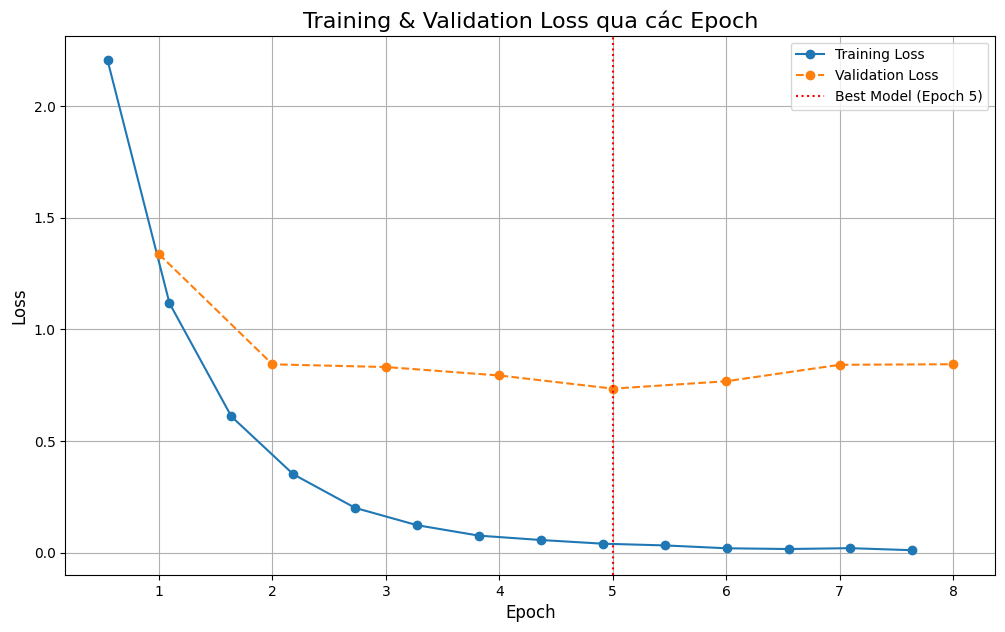

In [ ]:
# Lấy toàn bộ log trong quá trình training từ Trainer
log_history = trainer.state.log_history

# Tách riêng log cho training loss (chỉ 'loss', không bao gồm 'eval_loss')
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]

# Tách riêng log cho validation loss ('eval_loss')
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Chuyển list log thành DataFrame để dễ xử lý và vẽ
train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

# Tạo khung hình cho biểu đồ
plt.figure(figsize=(12, 7))

# Vẽ đường training loss
# Nếu log có cột 'epoch' thì dùng epoch làm trục X
if 'epoch' in train_df.columns:
    plt.plot(train_df['epoch'], train_df['loss'], label='Training Loss', marker='o')
else:
    # Nếu không có epoch, tự tạo index theo số bước (step)
    plt.plot(range(1, len(train_df)+1), train_df['loss'], label='Training Loss', marker='o')

# Vẽ đường validation loss
plt.plot(eval_df['epoch'], eval_df['eval_loss'], label='Validation Loss', marker='o', linestyle='--')

# Tìm epoch tốt nhất (eval_loss nhỏ nhất) và vẽ đường dọc đánh dấu
best_epoch = eval_df.loc[eval_df['eval_loss'].idxmin()]
plt.axvline(x=best_epoch['epoch'], color='r', linestyle=':',
            label=f'Best Model (Epoch {best_epoch["epoch"]:.0f})')

# Cài đặt tiêu đề và nhãn
plt.title('Training & Validation Loss qua các Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Hiển thị chú thích, lưới, và định dạng trục X
plt.legend()
plt.grid(True)
plt.xticks(range(1, int(eval_df['epoch'].max()) + 1))

# Hiển thị biểu đồ
plt.show()

# Đánh giá và Lưu mô hình tốt nhất

- **Mục đích**:  
  - Xác định checkpoint mô hình tốt nhất trong quá trình huấn luyện.  
  - Đánh giá mô hình tốt nhất trên tập test.  
  - Lưu mô hình và tokenizer để tái sử dụng sau này.  

- **Quy trình**

1. **In ra thông tin checkpoint tốt nhất**  
     - `trainer.state.best_model_checkpoint`: đường dẫn checkpoint.  
     - `trainer.state.best_metric`: giá trị metric tốt nhất.  
     - `trainer.args.metric_for_best_model`: metric dùng để chọn mô hình (ở đây là `eval_loss`).  
     - `trainer.args.greater_is_better`: xác định chiều tối ưu (ở đây là `False` vì loss càng nhỏ càng tốt).  

In [ ]:
print("Best ckpt path:", trainer.state.best_model_checkpoint)
print("Best metric:", trainer.state.best_metric)
print("Metric for best model:", trainer.args.metric_for_best_model)
print("Greater is better?:", trainer.args.greater_is_better)


Best ckpt path: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/srl-checkpoints/checkpoint-4580
Best metric: 0.7349207997322083
Metric for best model: eval_loss
Greater is better?: False


 2. **Đánh giá mô hình trên tập test**  
     - Gọi `trainer.evaluate()` với `tokenized_datasets["test"]`.  
     - In ra các chỉ số đánh giá cuối cùng của mô hình.  

In [ ]:
# Đánh giá hiệu năng cuối cùng trên tập test
print("\n Đánh giá hiệu năng của MÔ HÌNH TỐT NHẤT trên tập test...")

# Trainer hiện tại đang giữ mô hình tốt nhất (đã được load lại sau training nhờ load_best_model_at_end=True)
# -> Thực hiện evaluate trên tập test để đo lường độ chính xác cuối cùng
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

# In ra kết quả đánh giá (precision, recall, f1, loss, ...)
print("\n--- Kết quả của mô hình TỐT NHẤT trên tập Test ---")
for key, value in test_results.items():
    # Hiển thị từng metric với 4 chữ số thập phân
    print(f"{key}: {value:.4f}")


 Đánh giá hiệu năng của MÔ HÌNH TỐT NHẤT trên tập test...



--- Kết quả của mô hình TỐT NHẤT trên tập Test ---
eval_loss: 0.7289
eval_precision: 0.6884
eval_recall: 0.8000
eval_f1-score: 0.7400
eval_runtime: 5.1335
eval_samples_per_second: 230.8380
eval_steps_per_second: 29.0250
epoch: 8.0000


 3. **Tạo đường dẫn để lưu mô hình cuối cùng**  
     - Đặt tên thư mục dễ hiểu hơn, ví dụ `"biobert-srl-best-model"`.  

In [ ]:
# Tạo đường dẫn để lưu mô hình TỐT NHẤT
final_model_path = os.path.join(model_output_dir, "biobert-srl-best-model") # Đổi tên cho rõ hơn

  4. **Lưu mô hình và tokenizer**  
     - Dùng `trainer.save_model()` để lưu model.  
     - Dùng `tokenizer.save_pretrained()` để lưu tokenizer tương ứng.  

In [ ]:
# Lưu lại mô hình tốt nhất vào thư mục đã định nghĩa
trainer.save_model(final_model_path)

# Lưu tokenizer tương ứng vào cùng thư mục (đảm bảo khi load lại vẫn chạy đúng)
tokenizer.save_pretrained(final_model_path)

# In ra thông báo để xác nhận đã lưu thành công
print(f"\n Đã lưu mô hình và tokenizer TỐT NHẤT vào: {final_model_path}")


 Đã lưu mô hình và tokenizer TỐT NHẤT vào: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/biobert-srl-best-model


 5. **Kết quả**  
     - Mô hình tốt nhất và tokenizer đã được lưu vào thư mục định nghĩa.  
     - Có thể tải lại sau này để inference hoặc fine-tune tiếp.  

# Dùng mô hình đã lưu để dự đoán (Inference)

- **Mục đích**:  
  - Tải lại mô hình BioBERT đã fine-tuned từ thư mục lưu trữ.  
  - Tạo pipeline cho tác vụ **NER (Token Classification)**.  
  - Thử dự đoán trên một câu mới để kiểm tra kết quả.  

- **Quy trình**

 1. **Khai báo đường dẫn**  
     - `final_model_path`: thư mục chứa mô hình tốt nhất đã lưu.  

In [ ]:
# Đường dẫn tới thư mục chứa mô hình cuối cùng bạn đã lưu
final_model_path = '/content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/biobert-srl-best-model'

 2. **Tải pipeline**  
     - Dùng `pipeline("ner")` với `model` và `tokenizer` trỏ tới `final_model_path`.  
     - Tham số `aggregation_strategy="simple"`: tự động gom các sub-token thành từ hoàn chỉnh.

In [ ]:
# Tải pipeline cho tác vụ "ner" (Token Classification) từ mô hình đã lưu
# aggregation_strategy="simple": tự động gộp các sub-token lại thành từ hoàn chỉnh
print(f"Đang tải pipeline từ: {final_model_path}")
srl_pipeline = pipeline(
    "ner",                      # Loại tác vụ: Named Entity Recognition (NER)
    model=final_model_path,     # Đường dẫn tới mô hình đã fine-tuned
    tokenizer=final_model_path, # Đường dẫn tới tokenizer tương ứng
    aggregation_strategy="simple"
)
print(" Tải pipeline thành công!")

Device set to use cuda:0


Đang tải pipeline từ: /content/drive/MyDrive/Colab Notebooks/Khoa_Luan_Tot_Nghiep/Finetuned_Models/biobert-srl-best-model
 Tải pipeline thành công!


3. **Dự đoán trên câu mới**  
     - Ví dụ: `"vitamin A encodes Gene B"`.  
     - Lấy kết quả dự đoán qua `srl_pipeline(text)`.  

In [ ]:
# Câu ví dụ để thử nghiệm mô hình
text = "vitamin A encodes Gene B"
print(f"\nCâu đầu vào: '{text}'")

# Lấy kết quả dự đoán từ pipeline
results = srl_pipeline(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Câu đầu vào: 'vitamin A encodes Gene B'



  4. **Xử lý kết quả**  
     - Nếu không có entity nào → in thông báo.  
     - Nếu có:  
       - Tách nhãn `entity_group` thành 2 phần: **predicate** và **argument**.  
       - In ra:  
         - Predicate  
         - Argument  
         - Text gốc  
         - Confidence Score (độ tin cậy).  

In [ ]:
# In ra kết quả dự đoán các vai trò ngữ nghĩa (SRL)
print("\nKết quả dự đoán các vai trò ngữ nghĩa (SRL):")

# Nếu không có kết quả nào (mô hình không phát hiện argument)
if not results:
    print("Mô hình không nhận dạng được argument nào.")
else:
    # Duyệt qua từng entity mà pipeline trả về
    for entity in results:
        # Tách predicate và argument từ nhãn
        try:
            full_label = entity['entity_group']  # Ví dụ: "encode-ARG0"

            # Chia chuỗi tại dấu '-' đầu tiên: predicate = "encode", arg_label = "ARG0"
            predicate, arg_label = full_label.split('-', 1)

            # In ra thông tin chi tiết của entity
            print(f"  - Predicate: {predicate}")
            print(f"    - Argument: {arg_label}")
            print(f"    - Text: '{entity['word']}'")  # Đoạn văn bản được nhận dạng
            print(f"    - Confidence Score: {entity['score']:.4f}\n")  # Độ tin cậy dự đoán

        # Trường hợp nhãn không đúng format (không tách được)
        except ValueError:
            print(f"  - Không thể phân tích nhãn: {entity}")


Kết quả dự đoán các vai trò ngữ nghĩa (SRL):
  - Predicate: encode.01
    - Argument: ARG-0
    - Text: 'vitamin a'
    - Confidence Score: 0.5182

  - Predicate: encode.01
    - Argument: ARG-1
    - Text: 'gene b'
    - Confidence Score: 0.8345



- **Kết quả**:  
  - Mô hình hiển thị các vai trò ngữ nghĩa (SRL) mà nó nhận diện được trong câu mới.  
  - Giúp kiểm chứng khả năng suy luận của mô hình sau fine-tuning.  